# C.008: wind speed time-series data compared with ENTSO-E wind power production
In this notebook you will process a file containing reanalysis data downloaded from the Copernicus Data Store (CDS) to extract a wind speed time-series to compare with historical generation data from the ENTSO-E Transparency Platform.

# Step 01: opening the file with xarray
`xarray` is a powerful open-source library designed to access and manipulate multi-dimensional data. With the `cfgrib` engine, [developed by ECMWF](https://github.com/ecmwf/cfgrib), we can access GRIB data using the `ecCodes` library.

We load the ERA5 file containing wind speed at 100m. 

In [1]:
import xarray as xr
d = xr.open_dataset('../data/download.grib')
d

<xarray.Dataset> Size: 28MB
Dimensions:     (time: 696, latitude: 61, longitude: 81)
Coordinates:
    number      int32 4B ...
  * time        (time) datetime64[ns] 6kB 2020-02-01 ... 2020-02-29T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 488B 60.0 59.75 59.5 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 648B -5.0 -4.75 -4.5 ... 14.5 14.75 15.0
    valid_time  (time) datetime64[ns] 6kB ...
Data variables:
    u100        (time, latitude, longitude) float32 14MB ...
    v100        (time, latitude, longitude) float32 14MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-22T19:38 GRIB to CDM+CF via cfgrib-0.9.1...

We create a wind speed variable as: $\mathrm{ws100}=\sqrt{\mathrm{u100}^2 + \mathrm{v100}^2}$

In [2]:
d = d.assign({'ws100': (d['u100']**2 + d['v100']**2)**0.5})

# Step 02: Plotting the data
Visualising the data is always a good way to spot inconsistencies or mistakes in the data retrieval. `xarray` offers many options to visualise the data ([tutorial](https://tutorial.xarray.dev/scipy-tutorial/04_plotting_and_visualization.html)).

A static plot (in this case for the first time step).

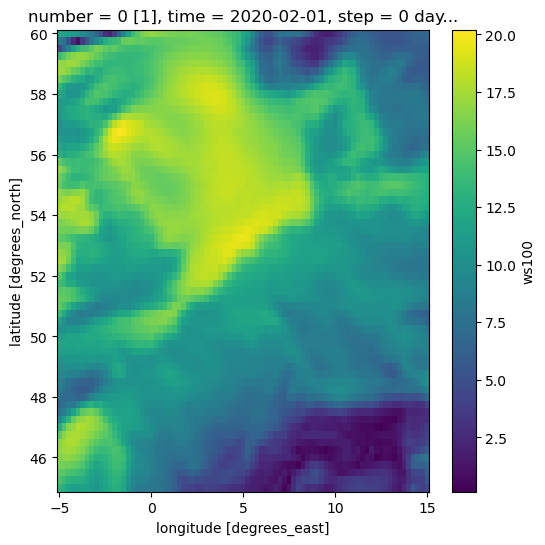

In [3]:
d.isel(time = 0)['ws100'].plot(aspect=1, size=6)

Another option is using [`HoloViews` library](https://holoviews.org/user_guide/Gridded_Datasets.html). This library gives the possibility to explore the data [interactively](https://hvplot.holoviz.org/user_guide/Interactive.html).

We use here a contour plot (`contourf`) but another option would be using a mesh ([`QuadMesh`](https://hvplot.holoviz.org/reference/xarray/quadmesh.html)).

We are not showing coast lines and using any projections because Google Colab doesn't work very well with `cartopy`. If you are working on a local environment you should be able to use the additional parameters of `contourf` or `quadmesh` to use a projection and show coastlines ([see here for a few examples](https://hvplot.holoviz.org/user_guide/Geographic_Data.html))

In [4]:
import hvplot.xarray # noqa
import hvplot as hv
import panel.widgets as pnw
import matplotlib.pyplot as plt

In [5]:

# by default this plot would use the `long_name` attribute as label, that for `time` would be `initial time of forecast`.
# I prefer using a shorter and more general name.
d.time.attrs['long_name'] = 'time'


d['ws100'].hvplot.contourf(
    cmap='viridis',
    widget_location='top',
    levels = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30],
    width=700, aspect = 1
    )


BokehModel(combine_events=True, render_bundle={'docs_json': {'8637d997-f5c8-49f9-befe-a2960d447447': {'version…

# Step 03: Aggregate/extract

Here we perform two things:
  1. We create a time-series averaging all the grid points in a box
  2. We extract the time-series from a specific location

The extraction is quite easy with `xarray`, we select a lat/lon location (in this case the location of the [Aikengall wind farm](https://www.thewindpower.net/windfarm_en_1550_aikengall.php) in Scotland) and we select the nearest grid point.

In [6]:
sel_lat  = 55.9150047
sel_lon = -2.49688
specific_location_ts = d.sel(latitude = sel_lat, longitude = sel_lon, method = 'nearest')['ws100']

The spatial aggreation is carried out selecting a rectangular box (in this case a box [roughly centred on Scotland](http://bboxfinder.com/#56.4,-6,57.85,-1.5) and perform a mean on the spatial dimensions.

In [7]:
lon_min = -6
lon_max = -1.5
lat_min = 56.4
lat_max = 57.85

box_ts = d.sel(latitude = slice(lat_max, lat_min), longitude = slice(lon_min, lon_max)).mean(dim = ['latitude', 'longitude'])['ws100']

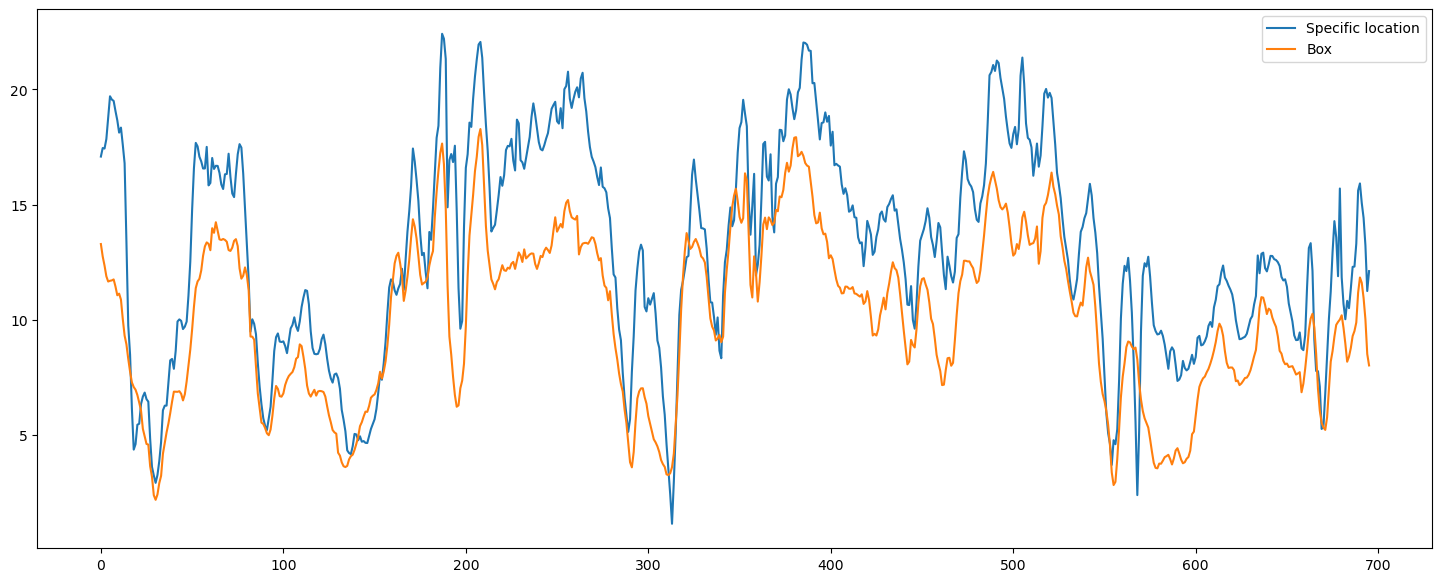

In [8]:
plt.rcParams['figure.figsize'] = [18, 7]
plt.plot(specific_location_ts, label = 'Specific location')
plt.plot(box_ts, label = 'Box')
plt.legend()
plt.show()

# Step 04: Downloading wind generation data
We can access wind generation data from the ENTSO-E Transparency Platform. We will download the data for the Scottish wind farm for February 2020. To use the ENTSO-E Transparency Platform's API you must [create a free account](https://transparency.entsoe.eu/usrm/user/createPublicUser), but as we did for the ERA5 data we download the data shared on Google Drive.

In [9]:
import pandas as pd
df = pd.read_parquet('../data/ENTSOE-TP-wind-20200201-20200229.parquet')

In [10]:
sel_gen = df[(  'AKGLW-2', 'Wind Onshore')]
sel_gen = sel_gen[sel_gen.index.minute == 0]
sel_gen.head()

2020-01-31 23:00:00+00:00    0.0
2020-02-01 00:00:00+00:00    0.0
2020-02-01 01:00:00+00:00    0.0
2020-02-01 02:00:00+00:00    0.0
2020-02-01 03:00:00+00:00    0.0
Name: (AKGLW-2, Wind Onshore), dtype: float64

# Step 05: Comparing wind speed with wind power generation
We can compare the three time-series using their normalised value (using a z-score transformation)

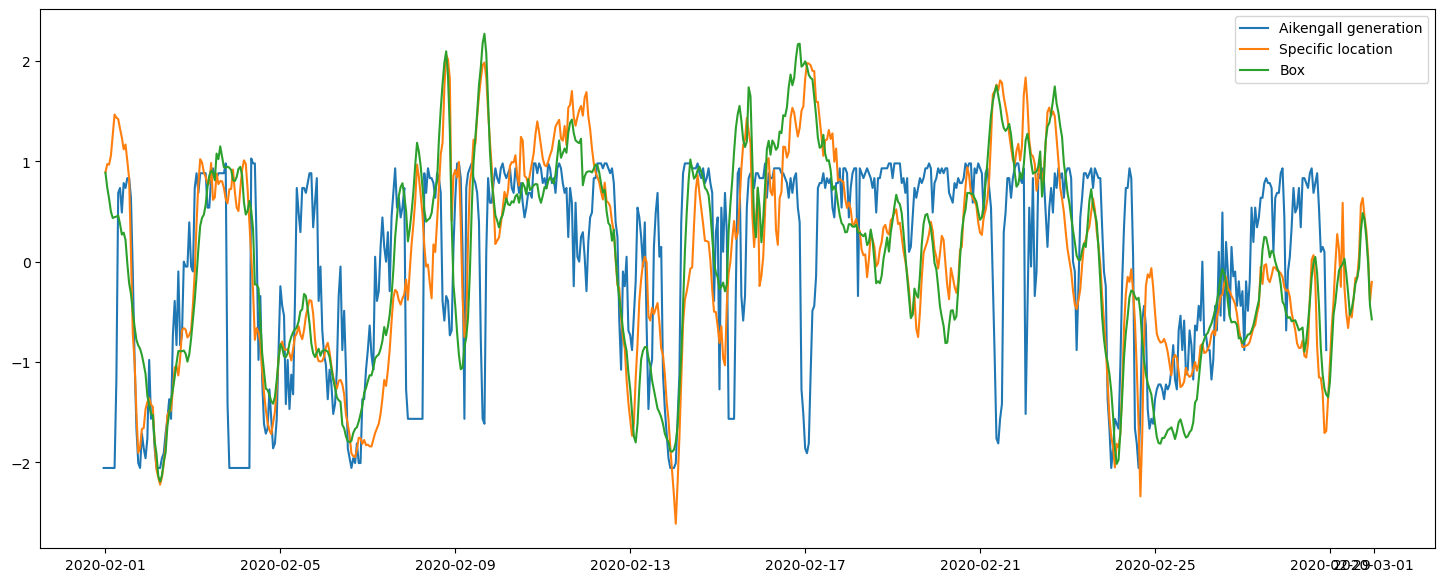

In [11]:
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [18, 7]
plt.plot(sel_gen.index, stats.zscore(sel_gen), label = 'Aikengall generation')
plt.plot(specific_location_ts['time'], stats.zscore(specific_location_ts), label = 'Specific location')
plt.plot(box_ts['time'], stats.zscore(box_ts), label = 'Box')
plt.legend()
